Data source imported: /Users/blakeweiss/.cache/kagglehub/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer/versions/1
  sample_id patient_cohort sample_origin  age sex  diagnosis stage  \
0        S1        Cohort1          BPTB   33   F          1   NaN   
1       S10        Cohort1          BPTB   81   F          1   NaN   
2      S100        Cohort2          BPTB   51   M          1   NaN   
3      S101        Cohort2          BPTB   61   M          1   NaN   
4      S102        Cohort2          BPTB   62   M          1   NaN   
5      S103        Cohort2          BPTB   53   M          1   NaN   
6      S104        Cohort2          BPTB   70   M          1   NaN   
7      S105        Cohort2          BPTB   58   F          1   NaN   
8      S106        Cohort2          BPTB   59   F          1   NaN   
9      S107        Cohort2          BPTB   56   F          1   NaN   

  benign_sample_diagnosis  plasma_CA19_9  creatinine     LYVE1      REG1B  \
0                    

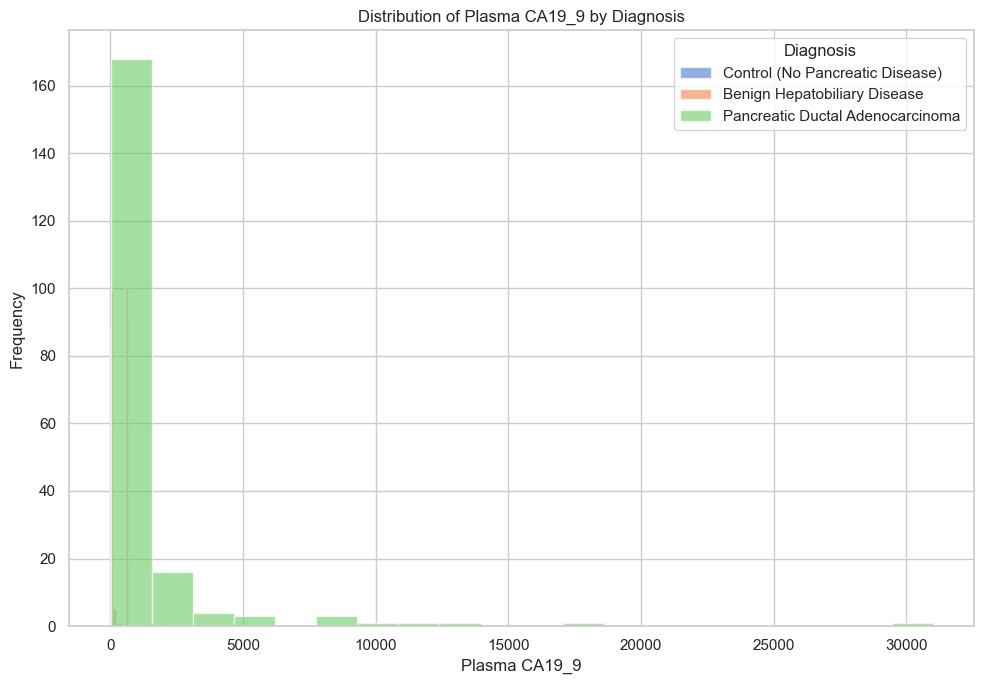

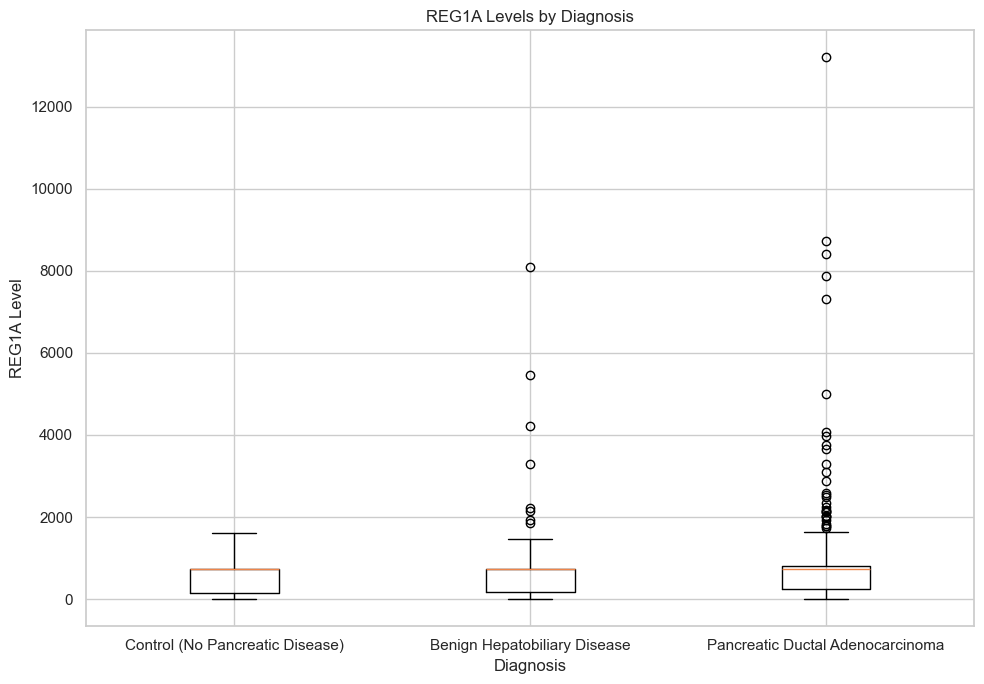

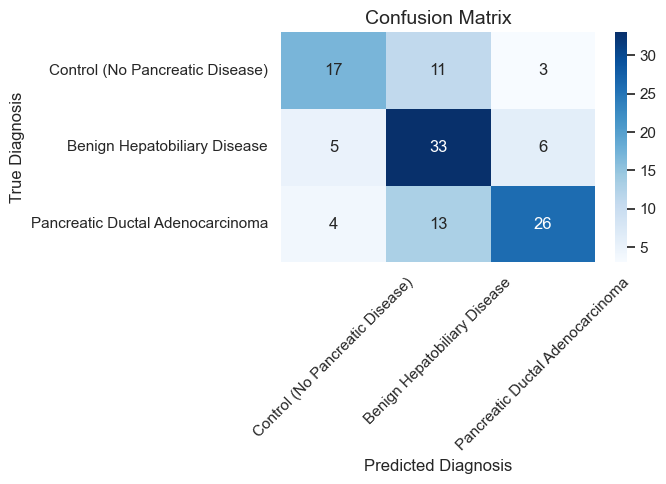

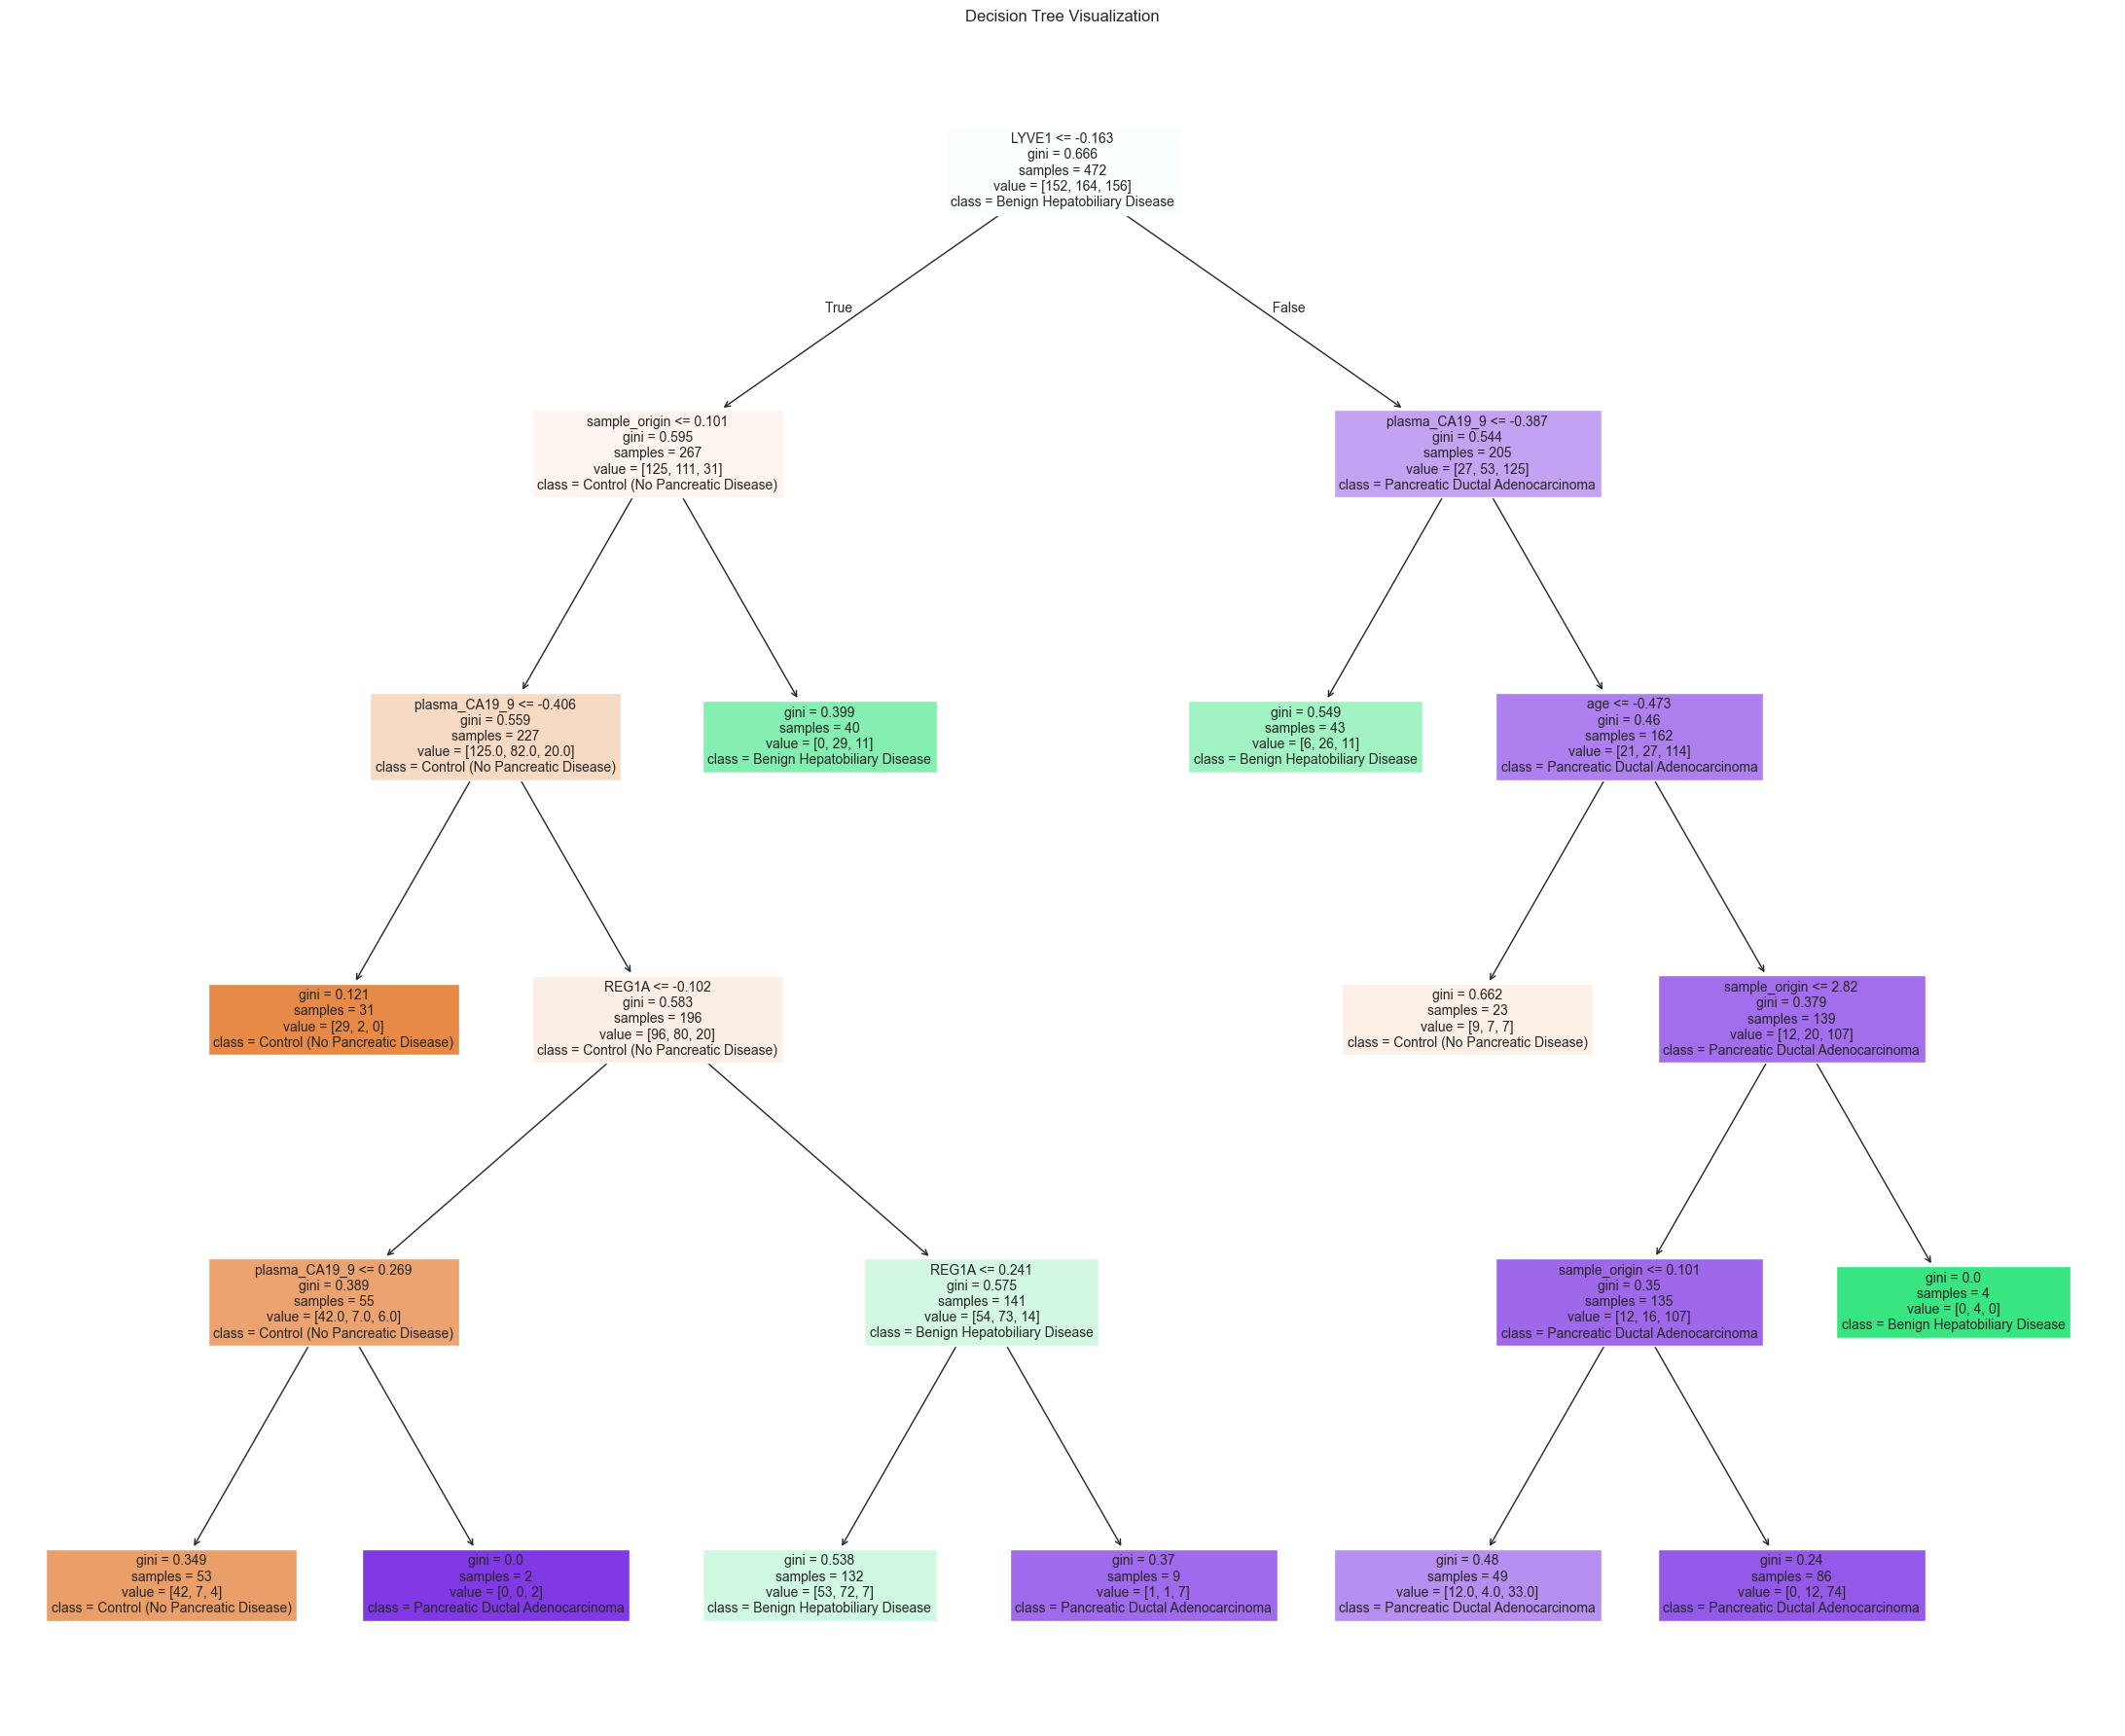

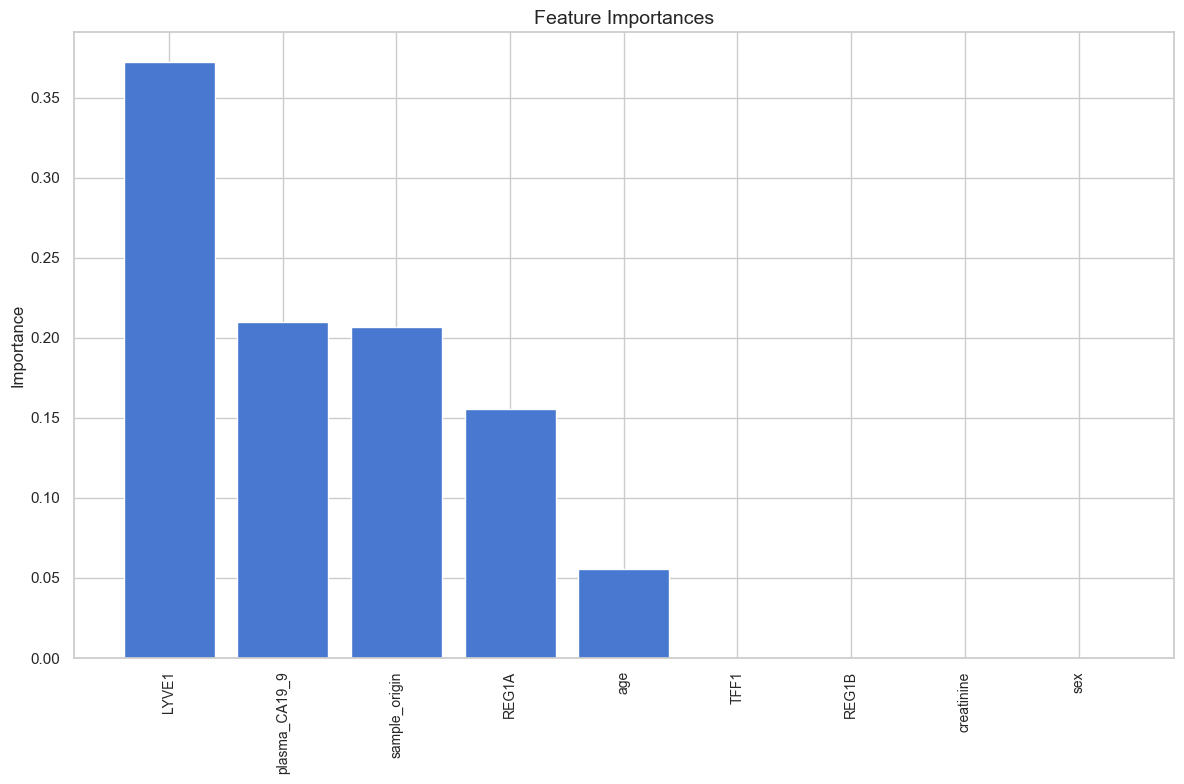


ANOVA test for plasma_CA19_9 by diagnosis:
F-statistic = 17.40, p-value = 4.57e-08
The amount of randomly selected patients are: 35

Overall Accuracy on Random Samples: 0.771

Results for the randomly selected patients:
Patient S467: | Predicted Diagnosis: Pancreatic Ductal Adenocarcinoma | True Diagnosis: Pancreatic Ductal Adenocarcinoma |
Patient S217: | Predicted Diagnosis: Benign Hepatobiliary Disease | True Diagnosis: Benign Hepatobiliary Disease |
Patient S446: | Predicted Diagnosis: Benign Hepatobiliary Disease | True Diagnosis: Pancreatic Ductal Adenocarcinoma |
Patient S372: | Predicted Diagnosis: Benign Hepatobiliary Disease | True Diagnosis: Benign Hepatobiliary Disease |
Patient S347: | Predicted Diagnosis: Benign Hepatobiliary Disease | True Diagnosis: Benign Hepatobiliary Disease |
Patient S180: | Predicted Diagnosis: Control (No Pancreatic Disease) | True Diagnosis: Control (No Pancreatic Disease) |
Patient S234: | Predicted Diagnosis: Benign Hepatobiliary Disease | Tru

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Pancreatic Cancer Predictive Model
This program trains a model to predict pancreatic cancer using urinary biomarkers.
The dataset is from the study "Urinary Biomarkers for Pancreatic Cancer" by Debernardi et al. (2020).

The diagnosis classes are defined as:
    1: Control (No Pancreatic Disease)
    2: Benign Hepatobiliary Disease (including chronic pancreatitis)
    3: Pancreatic Ductal Adenocarcinoma (Pancreatic Cancer)
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import joblib
import random
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy.stats import f_oneway


#Global Settings
SCRIPT_DIR = Path.cwd() # if using jupyter notebook, use this line
#SCRIPT_DIR = Path(__file__).parent  # Directory of this script. if using reg .py use this line
MODEL_FILENAME = 'pancreatic_cancer_decision_tree_predictor.pkl'
MODEL_PATH = SCRIPT_DIR / MODEL_FILENAME

#class labels for readability.
CLASS_LABELS = {
    1: "Control (No Pancreatic Disease)",
    2: "Benign Hepatobiliary Disease",
    3: "Pancreatic Ductal Adenocarcinoma"
}


#Data Loading and Preprocessing
def load_and_preprocess_data():
    """
    Downloads (if necessary) and loads the dataset cleans and preprocesses it.
    
    Returns:
        df (DataFrame): The preprocessed dataset with sample_id set as identifyer.
    """
    #download dataset using Kaggle.
    data_source = kagglehub.dataset_download("johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer")
    print('Data source imported:', data_source)
    
    #set the path to the downloaded dataset.
    data_dir = Path('/Users/blakeweiss/.cache/kagglehub/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer/versions/1')
    data_file = data_dir / 'Debernardi et al 2020 data.csv'
    
    if not data_file.exists():
        raise FileNotFoundError(f"Data file not found: {data_file}\nPlease check the path and ensure the dataset is correctly downloaded.")
    
    #read CSV data into a DataFrame.
    df = pd.read_csv(data_file)
    
    #print basic information.
    print(df.head(10))
    print("Data shape:", df.shape)
    print("Missing values per column:\n", df.isna().sum())
    
    #preserve 'sample_id' by setting it as the index/identifer.
    #drop other columns that are not useful (e.g., stage, benign_sample_diagnosis)
    #and drop 'patient_cohort' since the cohort doesn't matter.
    df.set_index('sample_id', inplace=True)
    df.drop(['stage', 'benign_sample_diagnosis', 'patient_cohort'], axis=1, inplace=True)
    
    #imputation: fill missing values in key biomarkers using the actual mean. this is meant to preserve accuracy and input missing values with means of said values 
    df['plasma_CA19_9'].fillna(df['plasma_CA19_9'].mean(), inplace=True)
    df['REG1A'].fillna(df['REG1A'].mean(), inplace=True)
    print("Missing values after cleaning:\n", df.isna().sum())
    
    #convert categorical text to numeric.
    df['sex'] = df['sex'].map({'M': 1, 'F': 0})
    df['sample_origin'] = df['sample_origin'].map({'BPTB': 0, 'LIV': 1, 'ESP': 2, 'UCL': 3})
    
    return df


#Model Training and Evaluation
def train_evaluate_model(X, y):
    """
    Trains a Decision Tree classifier in a Pipeline, evaluates it on a train-test split and cross-validation.
    
    Returns:
        pipeline: the trained scikit-learn Pipeline.
        X_test, y_test, y_pred: test split data and predictions.
    """
    #create a pipeline scaling followed by a Decision Tree classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(random_state=0))
    ])
    
    #split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    pipeline.fit(X_train, y_train)
    
    #train/Test scores
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    print('Decision Tree Classifier Train Score:', train_score)
    print('Decision Tree Classifier Test Score:', test_score)
    
    #classification report
    y_pred = pipeline.predict(X_test)
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    #ROC AUC for multiclass, if probabilities are available.
    if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
        y_prob = pipeline.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
        print("ROC AUC on Test Set (OVR):", roc_auc)
    
    #cross-validation evaluation.
    from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

    scoring = {
        'accuracy': 'accuracy',
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'roc_auc_ovr': 'roc_auc_ovr'  #built‑in multiclass OVR scorer
    }

    cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)

    print("\nCross‑Validation Scores (5‑Fold):")
    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"{metric}: Mean={scores.mean():.3f}, Std={scores.std():.3f}")
    
    return pipeline, X_test, y_test, y_pred


#Hyperparameter Tuning
def train_tuned_model(X_train, y_train, X_test, y_test):
    """Grid‐search to prune the tree and return the best pipeline."""
    
    #build the base pipeline
    base_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(random_state=0))
    ])
    
    
    #Grid search for hyperparameter tuning this is diffrent than random search it uses GridSearchCV
    param_grid = {
       'classifier__max_depth':           [None, 5, 10, 15, 20, 25],
       'classifier__min_samples_split':   [2, 5, 10, 20, 50, 100],
       'classifier__min_samples_leaf':    [1, 2, 5, 10, 20, 50]
    }
    
    grid = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    
    #RandomizedSearchCV for faster tuning randomized hyperparmeter tuning 
    # param_dist = {
    #     'classifier__max_depth':           [None, 5, 10, 15, 20, 25],
    #     'classifier__min_samples_split':   [2, 5, 10, 20, 50, 100],
    #     'classifier__min_samples_leaf':    [1, 2, 5, 10, 20, 50]
    # }
    
    # grid = RandomizedSearchCV(
    #     estimator=base_pipe,
    #     param_distributions=param_dist,
    #     n_iter=50,           # sample 50 random combos
    #     cv=5,
    #     scoring='accuracy',
    #     n_jobs=-1,
    #     random_state=42,
    #     verbose=1
    # )
    
    
    
    #fit the grid search
    grid.fit(X_train, y_train)

    #Report best parameters and CV score
    print("Best hyperparameters:", grid.best_params_)
    print(f"Best CV accuracy: {grid.best_score_:.3f}")

    #Evaluate on the test set
    best_pipe = grid.best_estimator_
    test_acc = best_pipe.score(X_test, y_test)
    print(f"Test accuracy (tuned): {test_acc:.3f}")

    #detailed classification report
    y_pred = best_pipe.predict(X_test)
    print("\nClassification Report (tuned):")
    print(classification_report(y_test, y_pred))

    return best_pipe


#Visualization Functions
def visualize_results(df, X, y, y_test, y_pred, pipeline):
    """Generates refined plots for data exploration and model evaluation"""
    
    #set a consistent overall seaborn style.
    sns.set(style="whitegrid", palette="muted")
    
    #Histogram of plasma_CA19_9 by diagnosis
    plt.figure(figsize=(10, 7))
    for label in sorted(df['diagnosis'].unique()):
        subset = df[df['diagnosis'] == label]
        plt.hist(subset['plasma_CA19_9'], bins=20, alpha=0.6, 
                 label=CLASS_LABELS.get(label, label))
    plt.xlabel('Plasma CA19_9')
    plt.ylabel('Frequency')
    plt.title('Distribution of Plasma CA19_9 by Diagnosis')
    plt.legend(title="Diagnosis")
    plt.tight_layout()
    plt.show()
    
    #Box Plot for REG1A by diagnosis
    plt.figure(figsize=(10, 7))
    data_to_plot = [df[df['diagnosis'] == label]['REG1A'] 
                    for label in sorted(df['diagnosis'].unique())]
    plt.boxplot(data_to_plot, labels=[CLASS_LABELS.get(label, label) 
                                      for label in sorted(df['diagnosis'].unique())])
    plt.title('REG1A Levels by Diagnosis')
    plt.xlabel('Diagnosis')
    plt.ylabel('REG1A Level')
    plt.tight_layout()
    plt.show()
    
    #Enhanced Confusion Matrix Heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                      xticklabels=[CLASS_LABELS.get(cls, str(cls)) for cls in sorted(y.unique())],
                      yticklabels=[CLASS_LABELS.get(cls, str(cls)) for cls in sorted(y.unique())])
    plt.xlabel("Predicted Diagnosis", fontsize=12)
    plt.ylabel("True Diagnosis", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    #Decision Tree Visualization
    plt.figure(figsize=(22, 18))
    plot_tree(pipeline.named_steps['classifier'],
              filled=True,
              feature_names=X.columns,
              class_names=[CLASS_LABELS.get(cls, str(cls)) for cls in sorted(y.unique())],
              fontsize=10)
    plt.title('Decision Tree Visualization')
    plt.tight_layout()
    plt.show()
    
    #Feature Importances
    importances = pipeline.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances", fontsize=14)
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90, fontsize=10)
    plt.ylabel("Importance", fontsize=12)
    plt.tight_layout()
    plt.show()

#Model Persistence and Inference
def save_model(pipeline):
    """Saves the trained model pipeline to disk."""
    joblib.dump(pipeline, MODEL_PATH)
    print(f'\nModel saved as {MODEL_PATH}')


def predict_cancer(input_data):
    """
    Diagnose pancreatic cancer from input data.
    
    Parameters:
        input_data (dict or pd.DataFrame): Data for one patient. The keys must match the training features.
        
    Returns:
        prediction (int): Predicted diagnosis.
    """
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data.copy()

    #load the saved model.
    model = joblib.load(MODEL_PATH)
    prediction = model.predict(input_df)
    return prediction[0]


#Main Function
def main():
    df = load_and_preprocess_data()
    
    #define features and target.
    target = 'diagnosis'
    X = df.drop(target, axis=1)  #sample_id is now the identifyer and is not used as a feature.
    y = df[target]
    
    #train and evaluate the model also split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    #hyperparameter tuning + training
    pipeline = train_tuned_model(X_train, y_train, X_test, y_test)

    #get predictions on the test set
    y_pred = pipeline.predict(X_test)
    
    #save the trained model.
    save_model(pipeline)
    
    #run visualizations and statistical tests.
    visualize_results(df, X, y, y_test, y_pred, pipeline)
    
    #additional statistical testing: ANOVA on plasma_CA19_9 across diagnoses.
    groups = [group['plasma_CA19_9'].values for _, group in df.groupby('diagnosis')]
    f_stat, p_val = f_oneway(*groups)
    print("\nANOVA test for plasma_CA19_9 by diagnosis:")
    print(f"F-statistic = {f_stat:.2f}, p-value = {p_val:.3g}")
    
    
    
    #randomly test patients 
    numoftestpatients=random.randint(10, 75)
    random_samples = df.sample(n=numoftestpatients, random_state=42)
    print("The amount of randomly selected patients are:", numoftestpatients)
    true_diagnoses = random_samples['diagnosis'].tolist()
    sample_inputs = random_samples.drop('diagnosis', axis=1)
    predictions = pipeline.predict(sample_inputs)
    
    accuracy = accuracy_score(true_diagnoses, predictions)
    print(f"\nOverall Accuracy on Random Samples: {accuracy:.3f}")
    
    predicted_labels = [CLASS_LABELS.get(pred, pred) for pred in predictions]
    true_labels = [CLASS_LABELS.get(label, label) for label in true_diagnoses]
    
    #print("\nPredicted Diagnoses for the random patients:", predicted_labels)
    #print("True Diagnoses for the random patients:", true_labels)
    print("\nResults for the randomly selected patients:")
    for idx, true_label, predicted_label in zip(random_samples.index, true_labels, predicted_labels):
        print(f"Patient {idx}: | Predicted Diagnosis: {predicted_label} | True Diagnosis: {true_label} |")
        
    
        
    #Uncomment the following lines to test the inference function with a sample input.
    """    # Uncomment the following lines to test the inference function with a sample input.
    # Example usage of the inference function for a single patient.
    sample_input_with_diag = df.iloc[[0]]
    true_diagnosis = sample_input_with_diag['diagnosis'].values[0]
    sample_input = sample_input_with_diag.drop('diagnosis', axis=1)
    prediction = predict_cancer(sample_input)
    predicted_label = CLASS_LABELS.get(prediction, prediction)
    true_label = CLASS_LABELS.get(true_diagnosis, true_diagnosis)
    print("\nPredicted Diagnosis for the sample patient:", predicted_label)
    print("True Diagnosis for the sample patient:", true_label)
    
    # Predict diagnoses for the first three patients from the dataset.
    sample_inputs = df.drop('diagnosis', axis=1).iloc[[0, 1, 2]]
    predictions = pipeline.predict(sample_inputs)
    predicted_labels = [CLASS_LABELS.get(pred, pred) for pred in predictions]
    print("\nPredicted Diagnoses for the 3 sample patients:", predicted_labels)
    """
    
    
    # Evaluate the model on the entire dataset.
    # Uncomment the following lines to evaluate the model on the entire dataset.
    #from sklearn.metrics import accuracy_score
    #y_pred_all = pipeline.predict(X)
    #overall_accuracy = accuracy_score(y, y_pred_all)
    #print(f"\nOverall Accuracy on Entire Dataset: {overall_accuracy:.3f}")

if __name__ == '__main__':
    main()